# **Audio Deephoax Detection Using DCGANs with Mel-Spectograms**

Mounting google drive to collab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Imports

In [2]:
import tensorflow as tf
import numpy as np
import os
import datetime
import librosa
import librosa.display
import matplotlib.pyplot as plt
import cv2
import random
from tensorflow.keras import layers, Input, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from IPython.display import Audio, display
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, confusion_matrix

4 Audio examples from the dataset

In [3]:
def display_audio_files(data_directory, num_files=3):

    real_dir = os.path.join(data_directory, 'realest')
    fake_dir = os.path.join(data_directory, 'fakest')

    # Check if the directories exist
    if not os.path.exists(real_dir):
        print(f"Error: Directory not found: {real_dir}")
        return
    if not os.path.exists(fake_dir):
        print(f"Error: Directory not found: {fake_dir}")
        return

    # Get the list of audio files in each directory
    real_audio = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith(('.wav', '.mp3'))][:2]
    fake_audio = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if f.endswith(('.wav', '.mp3'))][:2]

    print("Real Audio Examples:")
    if not real_audio:
        print("No audio files found in the 'real' directory.")
    else:
        for i, file_path in enumerate(real_audio):
            print(f"  [{i+1}] {os.path.basename(file_path)}")
            display(Audio(file_path))

    print("\nFake Audio Examples:")
    if not fake_audio:
        print("No audio files found in the 'fake' directory.")
    else:
        for i, file_path in enumerate(fake_audio):
            print(f"  [{i+1}] {os.path.basename(file_path)}")
            display(Audio(file_path))

data_directory = '/content/drive/MyDrive/for-dataset/bigtrain'
display_audio_files(data_directory)

Real Audio Examples:
  [1] file22233.wav


  [2] file22252.wav



Fake Audio Examples:
  [1] file31643.mp3


  [2] file31621.mp3


## **Preprocessing audio files to Mel-Spectogram**

Constants

In [4]:
SAMPLE_RATE = 22050
MAX_DURATION = 5
IMAGE_SIZE = 128
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 128
SEED = 42
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 1)
BUFFER_SIZE = 5000
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.00005
BETA_1 = 0.5

In [5]:
def generate_spectrograms(audio_path, image_size=IMAGE_SIZE, max_duration=MAX_DURATION, split_audio=True):
    try:
        y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)  # Load *without* a fixed duration initially
        audio_duration = librosa.get_duration(y=y, sr=sr)
    except Exception as e:
        print(f"Error loading audio file: {audio_path} - {e}")
        return []  # Return an empty list on error

    spectrograms = []  # Initialize an empty list to store spectrograms

    if audio_duration <= max_duration:
        # Pad or use as is
        if audio_duration < max_duration:
            # The change is here. Removing 'pad_mode' from fix_length
            y = librosa.util.fix_length(y, size=int(max_duration * sr))  # Pad with silence
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT,
                                                     hop_length=HOP_LENGTH, n_mels=N_MELS,
                                                     fmin=20, fmax=8000)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        img = cv2.resize(spectrogram_db, (image_size, image_size), interpolation=cv2.INTER_AREA)
        img = (img - np.mean(img)) / np.std(img)
        img = (img + 80) / 80
        img = (img * 2) - 1
        spectrograms.append(img) # Append the spectrogram to the list

    else:
        if split_audio:
            # Split audio into segments with overlap
            hop_samples = int(max_duration * sr * 0.5)
            for i in range(0, len(y) - int(max_duration * sr), hop_samples):
                segment = y[i:i + int(max_duration * sr)]
                spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=N_FFT,hop_length=HOP_LENGTH, n_mels=N_MELS, fmin=20, fmax=8000)
                spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
                img = cv2.resize(spectrogram_db, (image_size, image_size), interpolation=cv2.INTER_AREA)
                img = (img - np.mean(img)) / np.std(img)
                img = (img + 80) / 80
                img = (img * 2) - 1
                spectrograms.append(img)  # Append each segment's spectrogram
        else:
            # Truncate
            y = y[:int(max_duration * sr)]
            spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT,
                                                         hop_length=HOP_LENGTH, n_mels=N_MELS,
                                                         fmin=20, fmax=8000)
            spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
            img = cv2.resize(spectrogram_db, (image_size, image_size), interpolation=cv2.INTER_AREA)
            img = (img - np.mean(img)) / np.std(img)
            img = (img + 80) / 80
            img = (img * 2) - 1
            spectrograms.append(img)

    return spectrograms  # Return the list of spectrograms

def load_and_preprocess_data_for_dcgan(real_dir, fake_dir, image_size=IMAGE_SIZE, test_size=0.2, random_state=SEED, max_duration=MAX_DURATION, split_audio=True):
    #Loads audio, preprocesses into spectrograms, and splits into train/test.
    real_files = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith(('.wav', '.mp3'))]
    fake_files = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if f.endswith(('.wav', '.mp3'))]

    if not real_files and not fake_files:
        print("Error: No audio files found.")
        return None, None

    all_files = real_files + fake_files
    labels = [0] * len(real_files) + [1] * len(fake_files)

    file_label_pairs = list(zip(all_files, labels))
    train_files, test_files, train_labels, test_labels = train_test_split(
        all_files, labels, test_size=test_size, random_state=random_state, stratify=labels
    )

    train_spectrograms = []
    train_labels_extended = [] # To handle multiple spectrograms per file
    for i, audio_file in enumerate(train_files):
        print(f"Processing training file {i + 1}/{len(train_files)}: {audio_file}")
        spectrograms = generate_spectrograms(audio_file, image_size, max_duration, split_audio)
        if spectrograms:
            train_spectrograms.extend(spectrograms)
            train_labels_extended.extend([train_labels[i]] * len(spectrograms)) #duplicate labels
        else:
            print(f"Skipping training file {audio_file} due to error.")

    test_spectrograms = []
    test_labels_extended = []
    for i, audio_file in enumerate(test_files):
        print(f"Processing testing file {i + 1}/{len(test_files)}: {audio_file}")
        spectrograms = generate_spectrograms(audio_file, image_size, max_duration, split_audio)
        if spectrograms:
            test_spectrograms.extend(spectrograms)
            test_labels_extended.extend([test_labels[i]] * len(spectrograms))
        else:
            print(f"Skipping testing file {audio_file} due to error.")

    if not train_spectrograms or not test_spectrograms:
        print("Error: No spectrograms generated.")
        return None, None

    train_spectrograms = np.array(train_spectrograms)
    test_spectrograms = np.array(test_spectrograms)
    train_labels_extended = np.array(train_labels_extended)
    test_labels_extended = np.array(test_labels_extended)

    print(f"Training data shape: {train_spectrograms.shape}, labels: {train_labels_extended.shape}")
    print(f"Testing data shape: {test_spectrograms.shape}, labels: {test_labels_extended.shape}")
    return (train_spectrograms, train_labels_extended), (test_spectrograms, test_labels_extended)

if __name__ == '__main__':
    real_dir = '/content/drive/MyDrive/for-dataset/bigtrain/realest'
    fake_dir = '/content/drive/MyDrive/for-dataset/bigtrain/fakest'
    (train_data, train_labels), (test_data, test_labels) = load_and_preprocess_data_for_dcgan(
        real_dir, fake_dir, test_size=0.2, random_state=SEED, max_duration=5, split_audio=True
    )
    if train_data is not None and test_data is not None:
        print("Data loaded successfully!")


Processing training file 1/26756: /content/drive/MyDrive/for-dataset/bigtrain/realest/file17455.wav
Processing training file 2/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file1679.wav
Processing training file 3/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file10365.mp3
Processing training file 4/26756: /content/drive/MyDrive/for-dataset/bigtrain/realest/file14052.wav
Processing training file 5/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file205.mp3
Processing training file 6/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file25343.mp3
Processing training file 7/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file22151.mp3
Processing training file 8/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file31376.mp3
Processing training file 9/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file3074.mp3
Processing training file 10/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file3239.mp3
Processing t

/tmp/ipython-input-5-1282438138.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)  # Load *without* a fixed duration initially
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Streaming output truncated to the last 5000 lines.
Processing training file 4923/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file28359.wav
Processing training file 4924/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file31016.mp3
Processing training file 4925/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file2178.wav
Processing training file 4926/26756: /content/drive/MyDrive/for-dataset/bigtrain/realest/file14515.wav
Processing training file 4927/26756: /content/drive/MyDrive/for-dataset/bigtrain/realest/file1885.wav
Processing training file 4928/26756: /content/drive/MyDrive/for-dataset/bigtrain/realest/file12278.wav
Processing training file 4929/26756: /content/drive/MyDrive/for-dataset/bigtrain/realest/file19765.wav
Processing training file 4930/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file27217.mp3
Processing training file 4931/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file16762.mp3
Processing training file 4932

/tmp/ipython-input-5-1282438138.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)  # Load *without* a fixed duration initially
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Processing training file 9919/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file22507.mp3
Processing training file 9920/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file10306.mp3
Processing training file 9921/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file22925.mp3
Processing training file 9922/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file22002.mp3
Processing training file 9923/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file31371.mp3
Processing training file 9924/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file20066.mp3
Processing training file 9925/26756: /content/drive/MyDrive/for-dataset/bigtrain/realest/file1186.wav
Processing training file 9926/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file28845.mp3
Processing training file 9927/26756: /content/drive/MyDrive/for-dataset/bigtrain/realest/file11929.wav
Processing training file 9928/26756: /content/drive/MyDrive/for-dataset/bigtrain/

/tmp/ipython-input-5-1282438138.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)  # Load *without* a fixed duration initially
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Streaming output truncated to the last 5000 lines.
Processing training file 21166/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file25481.mp3
Processing training file 21167/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file10531.mp3
Processing training file 21168/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file24609.mp3
Processing training file 21169/26756: /content/drive/MyDrive/for-dataset/bigtrain/realest/file13738.wav
Processing training file 21170/26756: /content/drive/MyDrive/for-dataset/bigtrain/realest/file14461.wav
Processing training file 21171/26756: /content/drive/MyDrive/for-dataset/bigtrain/realest/file21309.wav
Processing training file 21172/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file17991.wav
Processing training file 21173/26756: /content/drive/MyDrive/for-dataset/bigtrain/realest/file10946.wav
Processing training file 21174/26756: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file22295.mp3
Processing trainin

/tmp/ipython-input-5-1282438138.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=SAMPLE_RATE)  # Load *without* a fixed duration initially
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Streaming output truncated to the last 5000 lines.
Processing testing file 1693/6689: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file16427.mp3
Processing testing file 1694/6689: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file25440.mp3
Processing testing file 1695/6689: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file14198.mp3
Processing testing file 1696/6689: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file10912.mp3
Processing testing file 1697/6689: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file140.mp3
Processing testing file 1698/6689: /content/drive/MyDrive/for-dataset/bigtrain/realest/file14368.wav
Processing testing file 1699/6689: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file15070.mp3
Processing testing file 1700/6689: /content/drive/MyDrive/for-dataset/bigtrain/realest/file23197.wav
Processing testing file 1701/6689: /content/drive/MyDrive/for-dataset/bigtrain/fakest/file2693.mp3
Processing testing file 1702/6689: /content/drive/

### **Examples of Mel-Spectograms**

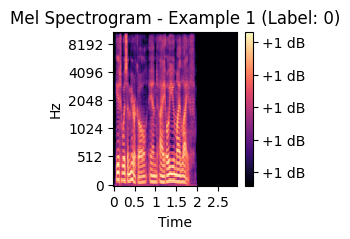

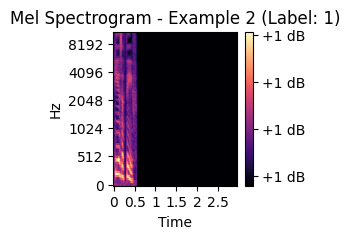

In [6]:
num_to_display = min(2, len(train_data))

for i in range(num_to_display):
    plt.figure(figsize=(2, 2))
    librosa.display.specshow(train_data[i], sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram - Example {i+1} (Label: {train_labels[i]})')
    plt.show()

## **Modified DCGANs Model to Cater Towards Audio/Spectograms Usage**

*   Base DCGANs model from: https://humboldt-wi.github.io/blog/research/information_systems_1819/generativemodels/
*   Paper based on that model: https://arxiv.org/pdf/1511.06434

In [7]:
L2_LAMBDA = 1e-4 # Define the L2 regularization factor

def make_discriminator(input_shape_tuple):
    model = tf.keras.Sequential(name="discriminator_classifier_l2_specaug")
    model.add(Input(shape=input_shape_tuple))
    model.add(layers.Conv2D(32, (4, 4), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(L2_LAMBDA)))
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(L2_LAMBDA)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(L2_LAMBDA)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(L2_LAMBDA)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(L2_LAMBDA)))
    return model

## **Training Model**

In [8]:
if train_data is not None and test_data is not None:
    print("Data loaded successfully.")

    #Prepare Data for Training
    print("Preparing data for TensorFlow...")

    if 'train_data' in locals() and isinstance(train_data, np.ndarray):
        if train_data.ndim == 3:
            print("Adding channel dimension to train_data...")
            train_data = train_data[..., tf.newaxis]
        train_data = train_data.astype('float32')

    if 'test_data' in locals() and isinstance(test_data, np.ndarray):
        if test_data.ndim == 3:
            print("Adding channel dimension to test_data...")
            test_data = test_data[..., tf.newaxis]
        test_data = test_data.astype('float32')

    train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
    test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

    print(f"Train data shape for model: {train_data.shape}, Train labels shape: {train_labels.shape}")
    print(f"Test data shape for model: {test_data.shape}, Test labels shape: {test_labels.shape}")

    if train_data.ndim != 4 or test_data.ndim != 4:
        raise ValueError("Incorrect data dimensions for model input.")

    train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    print("TensorFlow datasets created.")

    # Initializing
    tf.keras.backend.clear_session()
    classifier_model = make_discriminator(INPUT_SHAPE)
    classifier_model.summary()

    # Compiling
    print("Compiling the model...")
    loss_function = tf.keras.losses.BinaryCrossentropy()
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
        weight_decay=0.004
    )
    binary_acc_metric = tf.keras.metrics.BinaryAccuracy(name='bin_accuracy')
    auc_metric = tf.keras.metrics.AUC(name='auc')
    classifier_model.compile(optimizer=optimizer,
                              loss=loss_function,
                              metrics=[binary_acc_metric, auc_metric])

    # Setup Callbacks
    print("Setting up callbacks")
    checkpoint_dir = "./checkpoints_tuned_v3"
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, "audio_deepfake_detector_tuned_best_v3.keras")
    log_dir = "logs/fit_tuned_v3/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    os.makedirs(log_dir, exist_ok=True)
    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=False,
                                          monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15, verbose=1,
                                            mode='min', restore_best_weights=True)
    reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=1e-7)
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Training
    print(f"Starting training for up to {EPOCHS} epochs (Batch Size: {BATCH_SIZE})")
    history = classifier_model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=test_dataset,
        callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback, reduce_lr_callback]) # Added reduce_lr_callback
    print("Training finished.")

    # Basic Evaluation
    print("\n--- Basic Evaluation ---")
    eval_results = classifier_model.evaluate(test_dataset, verbose=2)
    print("\nTest Results:")
    print(f"{classifier_model.metrics_names[0]}: {eval_results[0]}") # Loss
    print(f"{binary_acc_metric.name}: {eval_results[1]}") # Accuracy
    print(f"{auc_metric.name}: {eval_results[2]}") # AUC

    # <<<--- DETAILED EVALUATION SECTION --- >>>
    print("\n--- Detailed Evaluation Metrics ---")
    # Need scikit-learn for these metrics
    from sklearn.metrics import classification_report, roc_curve

    # Get the raw prediction probabilities on the test set
    y_pred_proba = classifier_model.predict(test_dataset).ravel()

    # Get the true labels
    # This is a bit complex for tf.data.Dataset, so we'll re-create a numpy array
    y_true = test_labels.numpy() # Convert the tensor back to a numpy array

    # Convert probabilities to class labels based on a 0.5 threshold
    y_pred_class = (y_pred_proba > 0.5).astype(int)

    # 1. Precision, Recall, F1-Score
    print("\nClassification Report (0: Real, 1: Fake):")
    # Set zero_division=0 to handle cases where a class has no predictions
    print(classification_report(y_true, y_pred_class, target_names=['Real (0)', 'Fake (1)'], zero_division=0))

    # 2. Equal Error Rate (EER)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    fnr = 1 - tpr # False Negative Rate is 1 - True Positive Rate

    # Find the index where the difference between fpr and fnr is minimal
    eer_index = np.nanargmin(np.abs(fnr - fpr))
    # EER is the value of fpr/fnr at that index
    eer = fpr[eer_index]

    print(f"Equal Error Rate (EER): {eer:.4f} (or {eer*100:.2f}%)")
    print("-------------------------------------")

else:
    print("Data was not loaded (train_data or test_data is None). Skipping training.")

Data loaded successfully.
Preparing data for TensorFlow...
Adding channel dimension to train_data...
Adding channel dimension to test_data...
Train data shape for model: (28511, 128, 128, 1), Train labels shape: (28511,)
Test data shape for model: (7127, 128, 128, 1), Test labels shape: (7127,)
TensorFlow datasets created.


Model: "discriminator_classifier_l2_specaug"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 707,297 (2.70 MB)

 Trainable params: 706,401 (2.69 MB)

 Non-trainable params: 896 (3.50 KB)

Compiling the model...
Setting up callbacks
Starting training for up to 50 epochs (Batch Size: 64)
Epoch 1/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.5275 - bin_accuracy: 0.5520 - loss: 0.8239
Epoch 1: val_loss improved from inf to 0.49466, saving model to ./checkpoints_tuned_v3/audio_deepfake_detector_tuned_best_v3.keras
446/446 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - auc: 0.5276 - bin_accuracy: 0.5520 - loss: 0.8238 - val_auc: 0.9282 - val_bin_accuracy: 0.8189 - val_loss: 0.4947 - learning_rate: 5.0000e-05
Epoch 2/50
444/446 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - auc: 0.8000 - bin_accuracy: 0.7469 - loss: 0.5633
Epoch 2: val_loss improved from 0.49466 to 0.36535, saving model to ./checkpoints_tuned_v3/audio_deepfake_detector_tuned_best_v3.keras
446/446 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - auc: 0.8003 - bin_accuracy: 0.7471 - loss: 0.5629 - val_auc: 0.9321 - val_bin_accuracy: 0.8733 - val_loss: 0.3653 - learning_rate: 5.0000e-05
Epoch 3/50
445/446 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/ste

### Confusion Matrix

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Confusion Matrix:


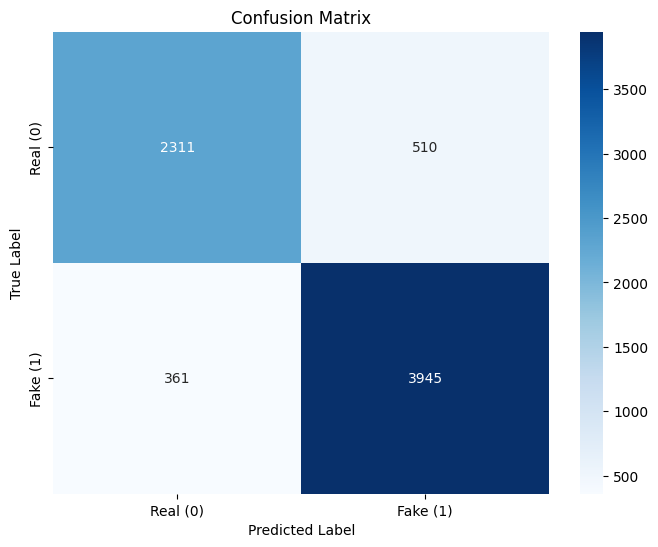

True Negatives (Real diprediksi Real): 2311
False Positives (Real diprediksi Fake): 510
False Negatives (Fake diprediksi Real): 361
True Positives (Fake diprediksi Fake): 3945


In [9]:
import seaborn as sns

# Get the raw prediction probabilities on the test set
y_pred_proba = classifier_model.predict(test_dataset).ravel()
y_true = test_labels.numpy() # Mengambil label asli dari test set

# Convert probabilities to class labels (0 or 1) using a 0.5 threshold
y_pred_class = (y_pred_proba > 0.5).astype(int)

# 3. Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred_class)

# Plot the confusion matrix using seaborn for a nice visual
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real (0)', 'Fake (1)'],
            yticklabels=['Real (0)', 'Fake (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# You can also print the values directly
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (Real diprediksi Real): {tn}")
print(f"False Positives (Real diprediksi Fake): {fp}")
print(f"False Negatives (Fake diprediksi Real): {fn}")
print(f"True Positives (Fake diprediksi Fake): {tp}")

## **Training Result**

In [10]:
print("Evaluating the final model (with best weights restored) on the test set...")
eval_results = classifier_model.evaluate(test_dataset, verbose=2)
print("\nTest Results:")
print(f"{classifier_model.metrics_names[0]}: {eval_results[0]}") # Loss
print(f"{binary_acc_metric.name}: {eval_results[1]}")            # Accuracy
print(f"{auc_metric.name}: {eval_results[2]}")                   # AUC
print("-------------------------------------")

print("Evaluating the final model (with best weights restored) on the test set...")
eval_results = classifier_model.evaluate(train_dataset, verbose=2)
print("\nTest Results:")
print(f"{classifier_model.metrics_names[0]}: {eval_results[0]}") # Loss
print(f"{binary_acc_metric.name}: {eval_results[1]}")            # Accuracy
print(f"{auc_metric.name}: {eval_results[2]}")                   # AUC
print("-------------------------------------")

Evaluating the final model (with best weights restored) on the test set...
112/112 - 1s - 7ms/step - auc: 0.9386 - bin_accuracy: 0.8778 - loss: 0.3559

Test Results:
loss: 0.35588765144348145
bin_accuracy: 0.8777886629104614
auc: 0.9385594129562378
-------------------------------------
Evaluating the final model (with best weights restored) on the test set...
446/446 - 4s - 9ms/step - auc: 0.9368 - bin_accuracy: 0.8770 - loss: 0.3577

Test Results:
loss: 0.35770314931869507
bin_accuracy: 0.8769948482513428
auc: 0.9367649555206299
-------------------------------------


### **Plotting the test results**

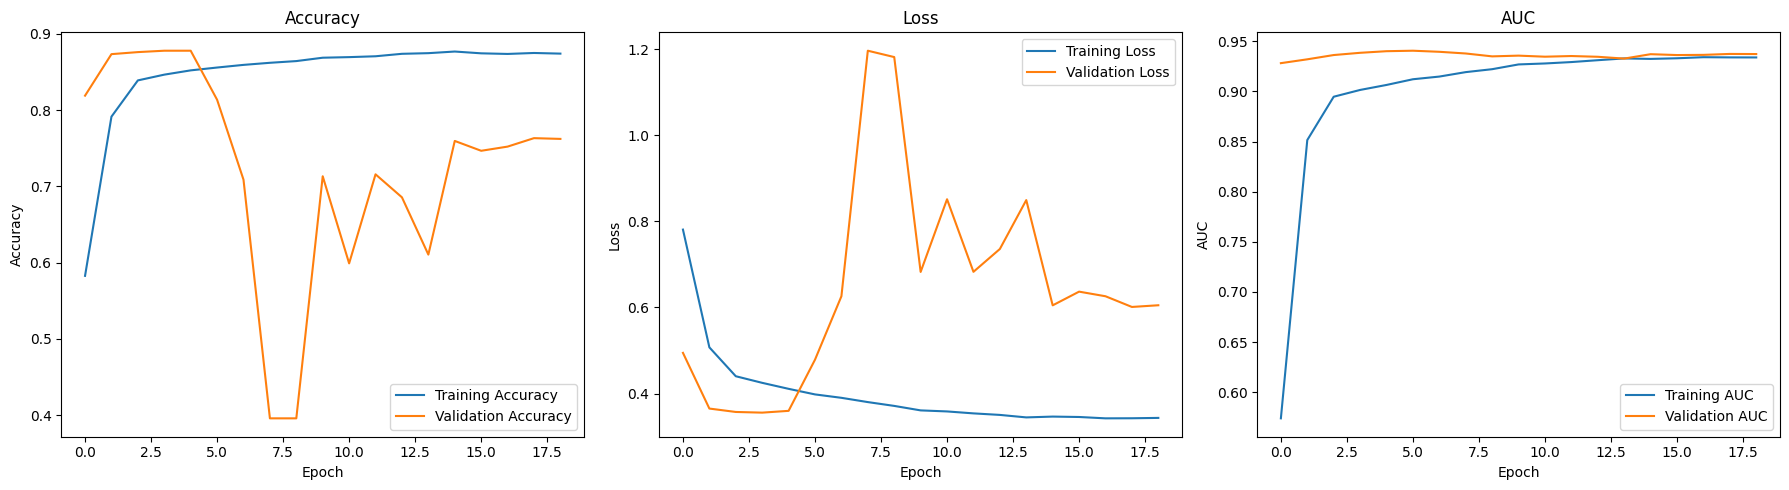

In [11]:
acc_key = 'bin_accuracy'
val_acc_key = 'val_bin_accuracy'
loss_key = 'loss'
val_loss_key = 'val_loss'
auc_key = 'auc'
val_auc_key = 'val_auc'
if not all(k in history.history for k in [acc_key, val_acc_key, loss_key, val_loss_key, auc_key, val_auc_key]):
     print("\nWarning: Could not find all expected keys in history object for plotting.")
     print(f"Available keys: {list(history.history.keys())}")
else:
    epochs_range = range(len(history.history[loss_key]))
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history.history[acc_key], label='Training Accuracy')
    plt.plot(epochs_range, history.history[val_acc_key], label='Validation Accuracy')
    plt.legend(loc='lower right'); plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history.history[loss_key], label='Training Loss')
    plt.plot(epochs_range, history.history[val_loss_key], label='Validation Loss')
    plt.legend(loc='upper right'); plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history.history[auc_key], label='Training AUC')
    plt.plot(epochs_range, history.history[val_auc_key], label='Validation AUC')
    plt.legend(loc='lower right'); plt.title('AUC'); plt.xlabel('Epoch'); plt.ylabel('AUC')
    plt.tight_layout(); plt.show()

**Inputting singular audio file to be checked/predicted on its authenticity**

In [15]:
# --- Prediction Function Definition ---
def predict_single_audio(input_audio_path, model_save_path, threshold=0.5):
    """Loads the model, preprocesses audio, and predicts if it's real or fake."""
    print(f"--- Inside predict_single_audio ---") # Added print
    print(f"Attempting to load model from: {model_save_path}")
    if not os.path.exists(model_save_path):
         print(f"Error: Model file not found at {model_save_path}")
         return

    try:
        # Load the trained model
        model = tf.keras.models.load_model(model_save_path)
        print("Model loaded successfully.")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    print(f"Processing audio file: {input_audio_path}")
    if not os.path.exists(input_audio_path):
         print(f"Error: Input audio file not found at {input_audio_path}")
         return

    try:
        spectrograms_list = generate_spectrograms(input_audio_path, image_size=IMAGE_SIZE, split_audio=True)
    except NameError as ne:
        print(f"Error: generate_spectrograms function or a required constant is not defined. {ne}")
        return
    except Exception as e:
        print(f"Error during spectrogram generation: {e}")
        return

    if not spectrograms_list:
        print("Could not generate spectrogram from the audio file.")
        return

    # Prepare for prediction
    spectrograms_np = np.array(spectrograms_list)
    spectrograms_np = spectrograms_np[..., tf.newaxis].astype('float32')
    print(f"Generated {spectrograms_np.shape[0]} spectrogram segment(s) with shape {spectrograms_np.shape[1:]}")

    # Make predictions
    print("Making predictions...")
    try:
        predictions = model.predict(spectrograms_np)
    except Exception as e:
        print(f"Error during prediction: {e}")
        return

    # Interpret predictions
    avg_prediction = np.mean(predictions)

    print("\n--- Prediction Results ---")
    print(f"Audio File: {os.path.basename(input_audio_path)}")

    if len(predictions) > 1:
      print("Predictions per segment:")
      for i, pred in enumerate(predictions):
          prob_fake = pred[0] * 100
          label = "Fake" if pred[0] > threshold else "Real"
          print(f"    Segment {i+1}: {label} (Probability Fake: {prob_fake:.2f}%)")

    avg_prob_fake = avg_prediction * 100
    avg_prob_real = (1-avg_prediction) * 100
    overall_label = "Fake" if avg_prediction > threshold else "Real"
    print(f"\nOverall Prediction: {overall_label} (Average Probability Fake: {avg_prob_fake:.2f}%)")
    print("--------------------------")
    print(f"Average Probability of Fake Audio: {avg_prob_fake:.2f}%)\nAverage Probability of Real Audio: {avg_prob_real:.2f}%")

model_save_path = "/content/checkpoints_tuned_v3/audio_deepfake_detector_tuned_best_v3.keras"
input_audio_folder = "/content/drive/MyDrive/for-dataset/input/"
input_audio_path = [os.path.join(input_audio_folder, f) for f in os.listdir(input_audio_folder) if f.endswith(('.wav', '.mp3'))][0]

model_exists = os.path.exists(model_save_path)
audio_exists = os.path.exists(input_audio_path)
#[os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith(('.wav', '.mp3'))]

print("--- Script Execution Started ---") # Added print
print(f"Checking model path: {model_save_path}")
print(f"Checking audio path: {input_audio_path}")


if model_exists and audio_exists:
    print("Paths exist. Attempting to call predict_single_audio...")
    try:
        predict_single_audio(input_audio_path, model_save_path)
    except Exception as call_e:
        print(f"An error occurred when calling predict_single_audio: {call_e}")
elif not model_exists:
    print(f"Error: Model file not found at the specified path: {model_save_path}")
    print("Prediction function will not be called.")
elif not audio_exists:
    print(f"Error: Input audio file not found at the specified path: {input_audio_path}")
    print("Prediction function will not be called.")

--- Script Execution Started ---
Checking model path: /content/checkpoints_tuned_v3/audio_deepfake_detector_tuned_best_v3.keras
Checking audio path: /content/drive/MyDrive/for-dataset/input/audio.mp3
Paths exist. Attempting to call predict_single_audio...
--- Inside predict_single_audio ---
Attempting to load model from: /content/checkpoints_tuned_v3/audio_deepfake_detector_tuned_best_v3.keras
Model loaded successfully.
Processing audio file: /content/drive/MyDrive/for-dataset/input/audio.mp3
Generated 1 spectrogram segment(s) with shape (128, 128, 1)
Making predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step

--- Prediction Results ---
Audio File: audio.mp3

Overall Prediction: Fake (Average Probability Fake: 90.46%)
--------------------------
Average Probability of Fake Audio: 90.46%)
Average Probability of Real Audio: 9.54%
